Importiamo tutte le librerie che ci interessano

In [1]:
import gym
import random
import numpy as np
from keras.layers import Input, Conv2D, Dense, MaxPooling2D , Flatten
from keras.models import Model, Sequential, load_model
from collections import deque
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


Creo l'ambiente SpaceInvaders-vo

In [215]:
env = gym.make('SpaceInvaders-v0')

Creiamo la nostra rete neurale

In [216]:
class DQN:
    def __init__(self, input_shape, output_shape, discount=0.99, update_target_every=10, memory_size=2000):
        self.input_shape=input_shape
        self.output_shape=output_shape
        self.discount=discount
        self.update_target_every=update_target_every
        self.policy_net=self.create_model()
        self.memory=deque(maxlen=memory_size)
        self.target_counter=0 
    
    def create_model(self):
        model=Sequential()
        model.add(Conv2D(input_shape=self.input_shape, filters=16, kernel_size=(8,8), strides=(4,4), padding="valid", 
                        activation="relu", use_bias=True,))
        model.add(Conv2D(filters=16, kernel_size=(4,4), strides=(2,2), padding="valid", 
                       activation="relu", use_bias=True,))
        #model.add(Conv2D(filters=32, kernel_size=(2,2), padding="valid", 
        #                activation="relu", use_bias=True,))
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_shape)) # era softmax
        adm=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss="mse", optimizer=adm, metrics=["accuracy"] )
        return model        

Definiamo tre metodi per preprocessare la nostra immagine croppandola e portandola ad una scala di grigi

In [217]:
def to_greyscale(img):
        return np.mean(img , axis=2).astype(np.uint8)

In [218]:
def downsample(img):
        return img[::2 , ::2]

In [219]:
def crop(img):
    return img[10:100 ,:]

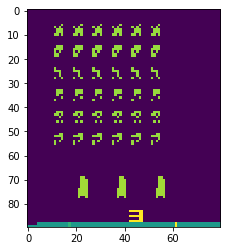

In [220]:
img = env.reset()
plt.imshow(preprocess(img))
#print(preprocess(img).shape)

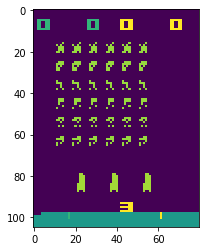

In [221]:
plt.imshow(to_greyscale(downsample(img)))

In [222]:
def preprocess(img):
        return crop(to_greyscale(downsample(img)))/255

Definiamo un metodo per trasformare ogni ricompensa in (-1, 0, +1)

In [223]:
def transform_reward(reward):
    return np.sign(reward)

In [224]:
class Memory:
    def __init__(self , memory = [] , maxsize = 10000):
            self.iteration = 0
            self.memory = memory
            self.maxsize = maxsize

In [225]:
def iteration(env  , model  , mem):
    env.reset()
    epsilon =  (0.995)**(mem.iteration)
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,90,80,1))
    mem.memory = []
    for i in range(mem.maxsize):
        if  random.random() < epsilon:
            ac = env.action_space.sample()
        else:
            ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        if done:
            next_processed_state = preprocess(next_state)
            next_processed_state = next_processed_state.reshape((1,90,80,1))
            mem.memory.append((processed_state,ac  , next_processed_state , reward, done ))
            break
        env.render()
        next_processed_state = preprocess(next_state)
        next_processed_state = next_processed_state.reshape((1,90,80,1))
        mem.memory.append((processed_state,ac  , next_processed_state , reward, done ))
        processed_state=next_processed_state
    mem.iteration=mem.iteration+1   

In [226]:
mem = Memory()
dqn = DQN((90,80,1),6)

In [227]:
dqn.policy_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 21, 19, 16)        1040      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 8, 16)          4112      
_________________________________________________________________
flatten_10 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               147584    
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 774       
Total params: 153,510
Trainable params: 153,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
iteration(env , dqn , mem)

In [ ]:
env.close()

In [ ]:
len(mem.memory)

In [ ]:
iteration(env , dqn , mem)

In [ ]:
len(mem.memory)

In [ ]:
mem.iteration

In [ ]:
dqn.policy_net.predict(mem.memory[0][0])

In [ ]:
for index, _  in enumerate(mem.memory):
    print(index , dqn.policy_net.predict(mem.memory[index][0]))

In [ ]:
for index, _  in enumerate(mem.memory):
    print(index ,mem.memory[index][3])

In [ ]:
env.close()

In [234]:
def preprocess_experience_replay(experience_replay):
    experience_replay= experience_replay[44:]
    length = len(experience_replay)-1
    new_experience_replay = []
    i=0
    while i < length:
        x1=(experience_replay[i])
        x2=(experience_replay[i+1])
        x3 = [np.maximum(x1[0], x2[0]) , x2[1] ,np.maximum(x1[2], x2[2]) , x1[3]+x2[3],x2[4]]
        new_experience_replay.append(x3)
        i=i+4
    return new_experience_replay 

In [235]:
def train ( mem , model,gamma = 0.99 ):
    mem.memory = preprocess_experience_replay(mem.memory)
    for state , action , next_state , reward ,done in mem.memory:
            #rewards = np.zeros(6)
            #rewards[action]=reward
            #q_values = np.zeros(6)
            #q_values[best]=1
            #target = rewards+ (  gamma * q_values)
            #target = target.reshape(1,6)
            target =model.policy_net.predict(state)[0]
            if not done:
                #best = np.argmax(model.policy_net.predict(next_state))
                target[action]= reward + gamma* np.max(model.policy_net.predict(next_state)[0])
            else:
                target[action]= 0
            target =target.reshape(1,6)
            model.policy_net.fit(state , target , verbose=0)

In [229]:
train(mem , dqn)

NameError: name 'preprocess_experience_replay' is not defined

In [231]:
iteration(env,dqn,mem)
env.close()

In [232]:
len(mem.memory)

1223

In [233]:
len(preprocess_experience_replay(mem.memory))

590

In [237]:
mem = Memory()
dqn = DQN((90,80,1),6)

In [245]:
for i in range(10000):
    train(mem , dqn)
    iteration(env,dqn,mem)
    env.close()
    print(f"iterazione: {mem.iteration}\t memoria: { len(mem.memory)}\t esplorazione: {(0.995)**(mem.iteration+1)}")
    #print("memoria" , len(mem.memory))
    #print("esplorazione" ,(0.995)**(mem.iteration+1))

iterazione: 1	 memoria: 541	 esplorazione: 0.990025
iterazione: 2	 memoria: 934	 esplorazione: 0.985074875
iterazione: 3	 memoria: 598	 esplorazione: 0.980149500625
iterazione: 4	 memoria: 715	 esplorazione: 0.975248753121875
iterazione: 5	 memoria: 493	 esplorazione: 0.9703725093562656
iterazione: 6	 memoria: 351	 esplorazione: 0.9655206468094842
iterazione: 7	 memoria: 414	 esplorazione: 0.9606930435754368
iterazione: 8	 memoria: 632	 esplorazione: 0.9558895783575596
iterazione: 9	 memoria: 694	 esplorazione: 0.9511101304657719
iterazione: 10	 memoria: 510	 esplorazione: 0.946354579813443
iterazione: 11	 memoria: 610	 esplorazione: 0.9416228069143757
iterazione: 12	 memoria: 988	 esplorazione: 0.9369146928798039
iterazione: 13	 memoria: 547	 esplorazione: 0.9322301194154049
iterazione: 14	 memoria: 676	 esplorazione: 0.9275689688183278
iterazione: 15	 memoria: 673	 esplorazione: 0.9229311239742362
iterazione: 16	 memoria: 521	 esplorazione: 0.918316468354365
iterazione: 17	 memoria: 

iterazione: 132	 memoria: 837	 esplorazione: 0.5134164023722474
iterazione: 133	 memoria: 643	 esplorazione: 0.5108493203603861
iterazione: 134	 memoria: 641	 esplorazione: 0.5082950737585842
iterazione: 135	 memoria: 813	 esplorazione: 0.5057535983897913
iterazione: 136	 memoria: 719	 esplorazione: 0.5032248303978423
iterazione: 137	 memoria: 406	 esplorazione: 0.5007087062458531
iterazione: 138	 memoria: 807	 esplorazione: 0.4982051627146238
iterazione: 139	 memoria: 505	 esplorazione: 0.4957141369010507
iterazione: 140	 memoria: 693	 esplorazione: 0.4932355662165454
iterazione: 141	 memoria: 812	 esplorazione: 0.4907693883854627
iterazione: 142	 memoria: 829	 esplorazione: 0.4883155414435354
iterazione: 143	 memoria: 313	 esplorazione: 0.4858739637363177
iterazione: 144	 memoria: 889	 esplorazione: 0.4834445939176361
iterazione: 145	 memoria: 789	 esplorazione: 0.4810273709480479
iterazione: 146	 memoria: 561	 esplorazione: 0.4786222340933077
iterazione: 147	 memoria: 834	 esplorazi

KeyboardInterrupt: 

In [ ]:
def play_network(env , model):
    env.reset()
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,90,80,1))
    for i in range(10000):
        ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        if done:
            break
        env.render() 

In [248]:
play_network(env , dqn)

In [246]:
env.close()

In [ ]:
#salviamo la rete
dqn.policy_net.save("modello_prova.h5")

In [ ]:
plt.imshow(mem.memory[540][0].reshape((90,80)))